# Media Exposure Patterns

In [1]:
import torch
import numpy as np
import pyro
import pyro.distributions as dist

# plotting libraries
import matplotlib.pyplot as plt

/Users/fahad/miniconda3/envs/BML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 - Simulating Data

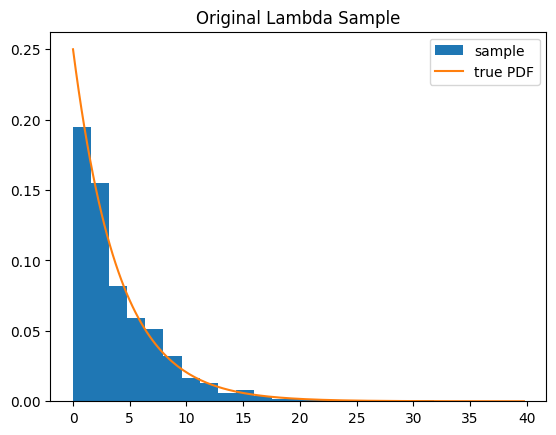

In [2]:
# Simulating Data

# draw lambda for 1000 individuals from a Gamma(1,0.25)
lambda_dist = dist.Gamma(1., 0.25 )
true_lambda = lambda_dist.sample([1000]) 

# get true pdf to compare:
x = np.arange(0,40,0.25)
p_x = lambda_dist.log_prob(x).exp() # this automatically computes the probability for a given distribution

plt.hist(true_lambda, bins=20, density=True, label="sample")
plt.plot(x,p_x,label="true PDF")
plt.title("Original Lambda Sample")
plt.legend(loc="upper right")
plt.show()

Text(0, 0.5, 'number of individuals with that count')

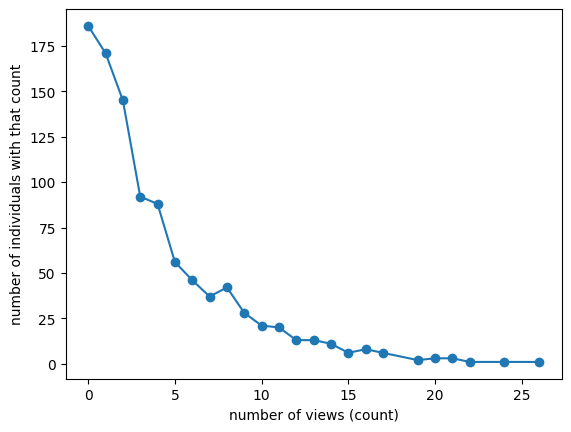

In [3]:
# draw an observation for each lambda from a Poisson(lambda)
views = dist.Poisson(true_lambda).sample()
num_views, counts = views.unique(return_counts=True)
plt.plot(num_views, counts, marker="o")
plt.xlabel("number of views (count)")
plt.ylabel("number of individuals with that count")

In [4]:
# Get the average number of views in the sample

views.mean().item()

3.9539999961853027

## 2 - Negative Binomial Model Fitting

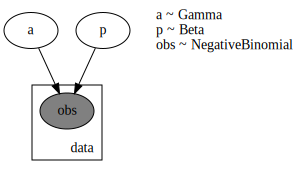

In [5]:
# %% ================ Part I =================
#         Population Parameter Estimation
#    =========================================

# Negative Binomial Model
# Prior: r ~ Gamma(1,1), p ~ Beta(1,1)
def simple_model(views=None):
    if views is None:
        N = 1
    else:
        N = views.shape[0]
    
    # Write Prior Here
    # name the parameters "r" and "p"
    a =  pyro.sample("a", dist.Gamma(1, 1))
    p =  pyro.sample("p", dist.Beta(1, 1))
    
    # Write NegativeBinomial Likelihood here in a plate of size N
    # return the pyro sample of views
    with pyro.plate("data", N):
        return pyro.sample("obs", dist.NegativeBinomial(a, p), obs=views)

pyro.render_model(simple_model, model_args=(views,), render_distributions=True)

Sample: 100%|██████████| 1200/1200 [00:06, 177.27it/s, step size=3.50e-01, acc. prob=0.933]


Posterior for a - mean: 1.07 , st.dev.: 0.06
Posterior for p - mean: 0.79 , st.dev.: 0.01


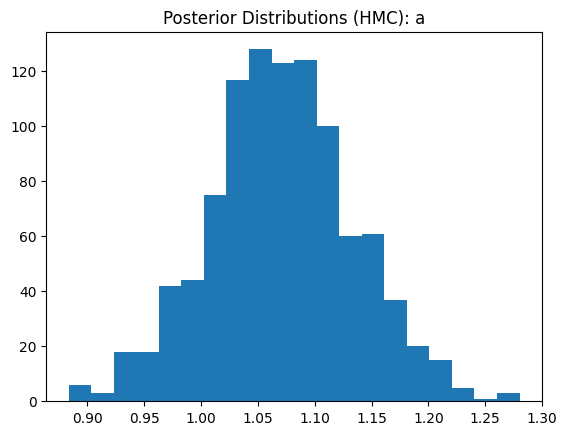

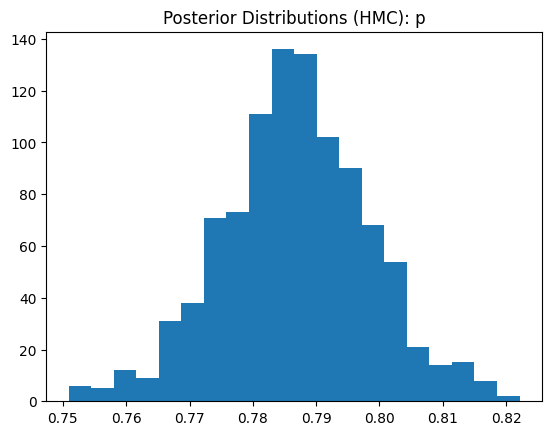

In [6]:
# %% Fit model with NUTS

from pyro.infer import MCMC, NUTS

# run MCMC and save the results in a dictionary named "hmc_samples"
# Warmup: 200, MCMC Samples: 1000
nuts_kernel = NUTS(simple_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(views)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

print("\nPosterior for a - mean: %.2f , st.dev.: %.2f" % (hmc_samples['a'].mean(),hmc_samples['a'].std()) )
print("Posterior for p - mean: %.2f , st.dev.: %.2f" % (hmc_samples['p'].mean(),hmc_samples['p'].std()) )

# Plot posterior distribution of Negative binomial
plt.hist(hmc_samples['a'], bins=20)
plt.title("Posterior Distributions (HMC): a")
plt.show()

plt.hist(hmc_samples['p'], bins=20)
plt.title("Posterior Distributions (HMC): p")
plt.show()

## 3 - Posterior Distribution for Gamma Parameterization

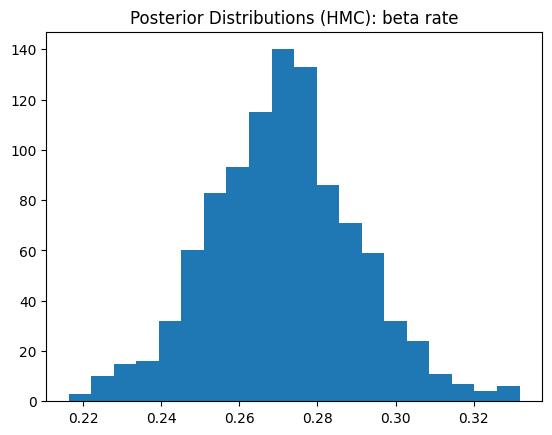

In [7]:
# %% convert to GammaPoisson parameters
beta_samples = (1 - hmc_samples['p']) / hmc_samples['p']
plt.hist(beta_samples, bins=20)
plt.title("Posterior Distributions (HMC): beta rate")
plt.show()

In [8]:
beta_samples.mean()

np.float32(0.27127764)

## 4 - Individual Level Prediction

In [12]:
# %% =============== Part II =================
#    Individual level prediction using Sample Importance Resampling
#    =========================================

x = torch.tensor(5)

# Sample 5000 lambdas from new prior
# since we have 1000 draws from a,b, you can use .sample([5]) to get 5 draws for each
lambda_new_prior = dist.Gamma(torch.tensor(hmc_samples['a']), torch.tensor(beta_samples)).sample([5])
lambda_new_prior = lambda_new_prior.flatten() # flatten to shape = [5000]

print("Prior mean for lambda: %.2f" % lambda_new_prior.mean())
lambda_new_prior.mean()

Prior mean for lambda: 4.00


tensor(4.0002)

Posterior mean for lambda (given x=5): 4.86


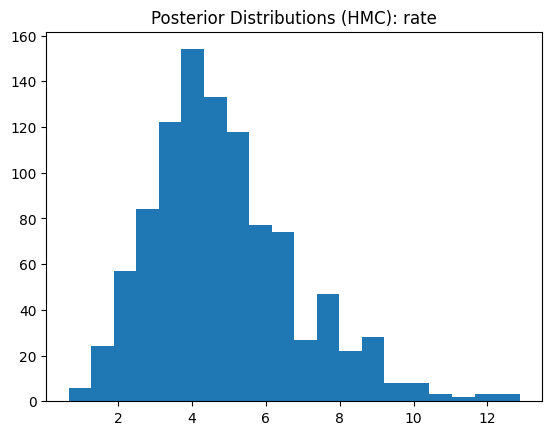

tensor(4.8618)

In [13]:
# unnormalized weight: Likelihood P(x|lambda)
# you can use .log_prob(x).exp() to get the probabilities from the relevant distribution
p_x_lambda = dist.Poisson(lambda_new_prior).log_prob(x).exp()

# get weights for each lambda from the prior
weight_normalized = p_x_lambda / p_x_lambda.sum()

# resampling
lambda_indices = np.random.choice(weight_normalized.shape[0],size=1000, p=weight_normalized.numpy())
lambda_posterior_sample = lambda_new_prior[lambda_indices]

print("Posterior mean for lambda (given x=%d): %.2f" % (x,lambda_posterior_sample.mean()) )

# %% Plot P(lambda|x, Data)
plt.hist(lambda_posterior_sample, bins=20, label="r")
plt.title("Posterior Distributions (HMC): rate")
plt.show()

lambda_posterior_sample.mean()

## Appendix: Sample Importance Resampling (SIR)

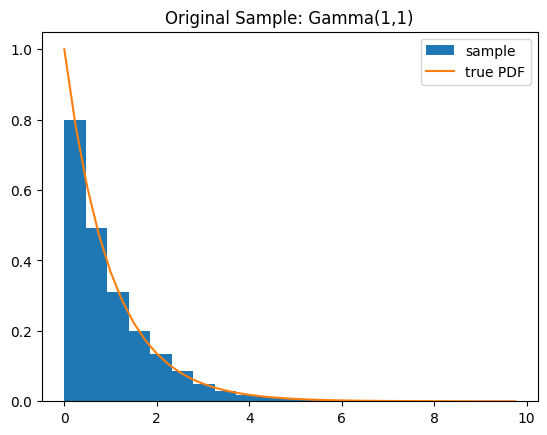

In [13]:
# Here we are going to get a sample from a Gamma(2,2) starting only with a sample from a Gamma(1,1)

# import torch
# import numpy as np
# import pyro.distributions as dist

# # plotting libraries
# import matplotlib.pyplot as plt


# %% Step 1 - Sampling: Draw 1000 samples from Gamma(1,1)
original_dist = dist.Gamma(torch.tensor(1.), torch.tensor(1.))
original_sample = original_dist.sample([10000])

# True pdf:
x = np.arange(0,10,0.25)
p_x = original_dist.log_prob(x).exp()

plt.hist(original_sample, bins=20, density=True, label="sample")
plt.plot(x,p_x,label="true PDF")
plt.title("Original Sample: Gamma(1,1)")
plt.legend(loc="upper right")
plt.show()

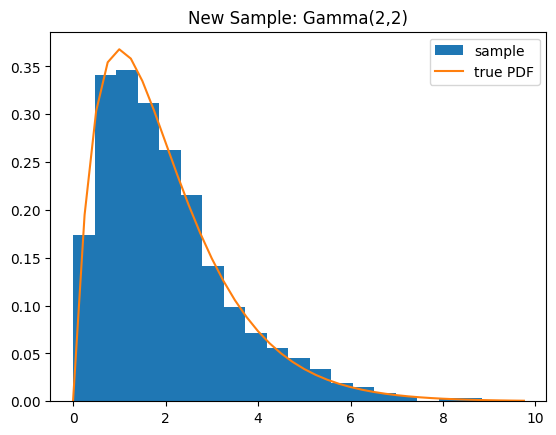

New mean: 2.03


In [14]:
# %% Step 2 - Compute importance:
new_dist = dist.Gamma(torch.tensor(2.), torch.tensor(1.))
    
p_old = original_dist.log_prob(original_sample).exp()
p_new = new_dist.log_prob(original_sample).exp()

weight_unnormalized = p_new / p_old
weight_normalized = weight_unnormalized / weight_unnormalized.sum()


# %% Step 3 - Resampling

# draw 1000 indices from the original sample based on computed importance weights
x_indices = np.random.choice(weight_normalized.shape[0],size=10000, p=weight_normalized.numpy())

# get new sample
new_sample = original_sample[x_indices]

# True pdf:
x = np.arange(0,10,0.25)
p_x = new_dist.log_prob(x).exp()

plt.hist(new_sample, bins=20, density=True, label="sample")
plt.plot(x,p_x,label="true PDF")
plt.title("New Sample: Gamma(2,2)")
plt.legend(loc="upper right")
plt.show()

print("New mean: %.2f" % new_sample.mean())